In [1]:
from __future__ import print_function

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [3]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical

Using TensorFlow backend.


In [4]:
batch_size = 128
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 100
epsilon_std = 1.0
num_classes = 10

In [5]:
#load mnist dataset
(x_train, y_train_), (x_test, y_test_) = mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
y_train = to_categorical(y_train_, num_classes)
y_test = to_categorical(y_test_, num_classes)

In [6]:
#encoder
x = Input(shape = (original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

In [7]:
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [8]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape = (K.shape(z_mean)[0], latent_dim), mean = 0., stddev = epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [9]:
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [10]:
#decoder
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [11]:
#build model
vae = Model(x, x_decoded_mean)

In [12]:
#compute loss = reconstruction error + KL divegence
xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis = -1)
vae_loss = K.mean(xent_loss + kl_loss)

In [13]:
vae.add_loss(vae_loss)
vae.compile(optimizer = 'adam')
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

In [14]:
vae.fit(x_train,
       shuffle = True,
       epochs = epochs,
       batch_size = batch_size,
       validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 11s 185us/step - loss: 203.9913 - val_loss: 175.8847
Epoch 2/100
60000/60000 [==============================] - 10s 160us/step - loss: 171.8225 - val_loss: 168.1392
Epoch 3/100
60000/60000 [==============================] - 10s 174us/step - loss: 166.6923 - val_loss: 165.3431
Epoch 4/100
60000/60000 [==============================] - 12s 193us/step - loss: 164.4619 - val_loss: 163.7404
Epoch 5/100
60000/60000 [==============================] - 12s 197us/step - loss: 162.9976 - val_loss: 162.5389
Epoch 6/100
60000/60000 [==============================] - 10s 165us/step - loss: 161.8812 - val_loss: 161.6204
Epoch 7/100
60000/60000 [==============================] - 14s 229us/step - loss: 160.8539 - val_loss: 160.5659
Epoch 8/100
60000/60000 [==============================] - 13s 213us/step - loss: 159.8860 - val_loss: 160.0246
Epoch 9/100
60000/60000 [=============================

60000/60000 [==============================] - 17s 276us/step - loss: 146.1622 - val_loss: 150.0768
Epoch 74/100
60000/60000 [==============================] - 17s 281us/step - loss: 146.1087 - val_loss: 150.1533
Epoch 75/100
60000/60000 [==============================] - 19s 309us/step - loss: 146.0736 - val_loss: 150.2190
Epoch 76/100
60000/60000 [==============================] - 17s 283us/step - loss: 146.0027 - val_loss: 150.0719
Epoch 77/100
60000/60000 [==============================] - 16s 273us/step - loss: 145.9519 - val_loss: 150.2276
Epoch 78/100
60000/60000 [==============================] - 18s 302us/step - loss: 145.9181 - val_loss: 150.1973
Epoch 79/100
60000/60000 [==============================] - 17s 276us/step - loss: 145.8305 - val_loss: 150.0902
Epoch 80/100
60000/60000 [==============================] - 17s 276us/step - loss: 145.8053 - val_loss: 149.9754
Epoch 81/100
60000/60000 [==============================] - 18s 305us/step - loss: 145.7310 - val_loss: 149.9

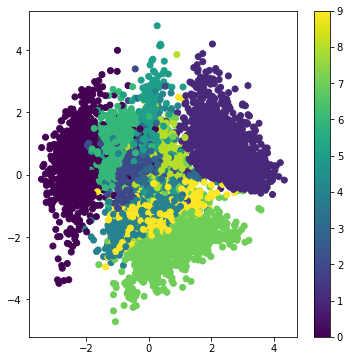

In [15]:
#plot the distribution of the code of different classes
encoder = Model(x, z_mean)
x_test_encoded = encoder.predict(x_test, batch_size = batch_size)
plt.figure(figsize=(6,6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c = y_test_)
plt.colorbar()
plt.show()

In [16]:
#build generator
decoder_input = Input(shape = (latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [17]:
#plot how these two dimensions affect the output
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

In [18]:
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]

In [19]:
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded.reshape(digit_size, digit_size)
        figure[i*digit_size : (i+1)*digit_size, j*digit_size : (j+1)*digit_size] = digit

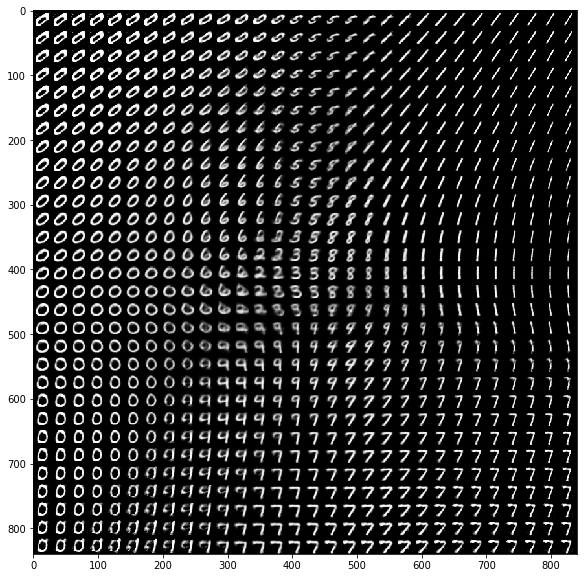

In [20]:
plt.figure(figsize=(10,10))
plt.imshow(figure, cmap = 'Greys_r')
plt.show()